In [45]:
#Stefans document
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
import re
from scipy.signal import find_peaks
plt.rcParams['figure.dpi'] = 150



cm = 1.5/2.54 #define ratio for cm and inches

In [46]:
Data_names = []

# Method for going through all the data we have, and it fucking works dawg
for (dir_path, dir_names, file_names) in os.walk('./Data_Labday_2'):
    for file_name in file_names:
        if file_name.endswith('.txt'): #ensures we grab only the files ending with .txt
            Data_names.append(os.path.join(dir_path, file_name))

In [47]:
time = [] #array for all time data lists
V1 = [] #Same again for votlage readings

for Data_name in Data_names:
    Data = np.loadtxt(Data_name, skiprows=3)
    time.append(np.linspace(0, 10, len(Data[:, 0])))
    V1.append(Data[:, 1])  # Assuming V1 is in the first column
    #print(time)
    #print(V1)

In [48]:
#Here we make the functions for the fits used
#Guesses for the linear function
a_lin_guess = 0.6 
n_lin_guess = 21e-7
offset_lin_guess = 0.4
p0_lin = [a_lin_guess, n_lin_guess, offset_lin_guess]

l = 0.065 #cm length of weird tube we compress the air in
freq_constant = (2*np.pi)/(633e-9)*l

#Linear fit function hoping that it works on a linear fit
def Linear_fit(t, *p): 
    amplitude = p[0]
    n = p[1]
    offset = p[2]
    return amplitude *(np.cos(freq_constant*2*(n-1)*t)) + offset

#Guesses for the quadratic fit
a_quad_guess = 0.7
n_quad_guess = 21
offset_quad_guess = 0.4
m_quad_guess = 0
p0_Quad = [a_quad_guess, n_quad_guess, offset_quad_guess, m_quad_guess]

#Quadratic fit function if it works like this
def Quad_fit(t, *p): 
    amplitude = p[0]
    n = p[1]
    offset = p[2]
    m = p[3]
    return amplitude *(np.cos(freq_constant*2*((n-1)*t**2+m*t))) + offset

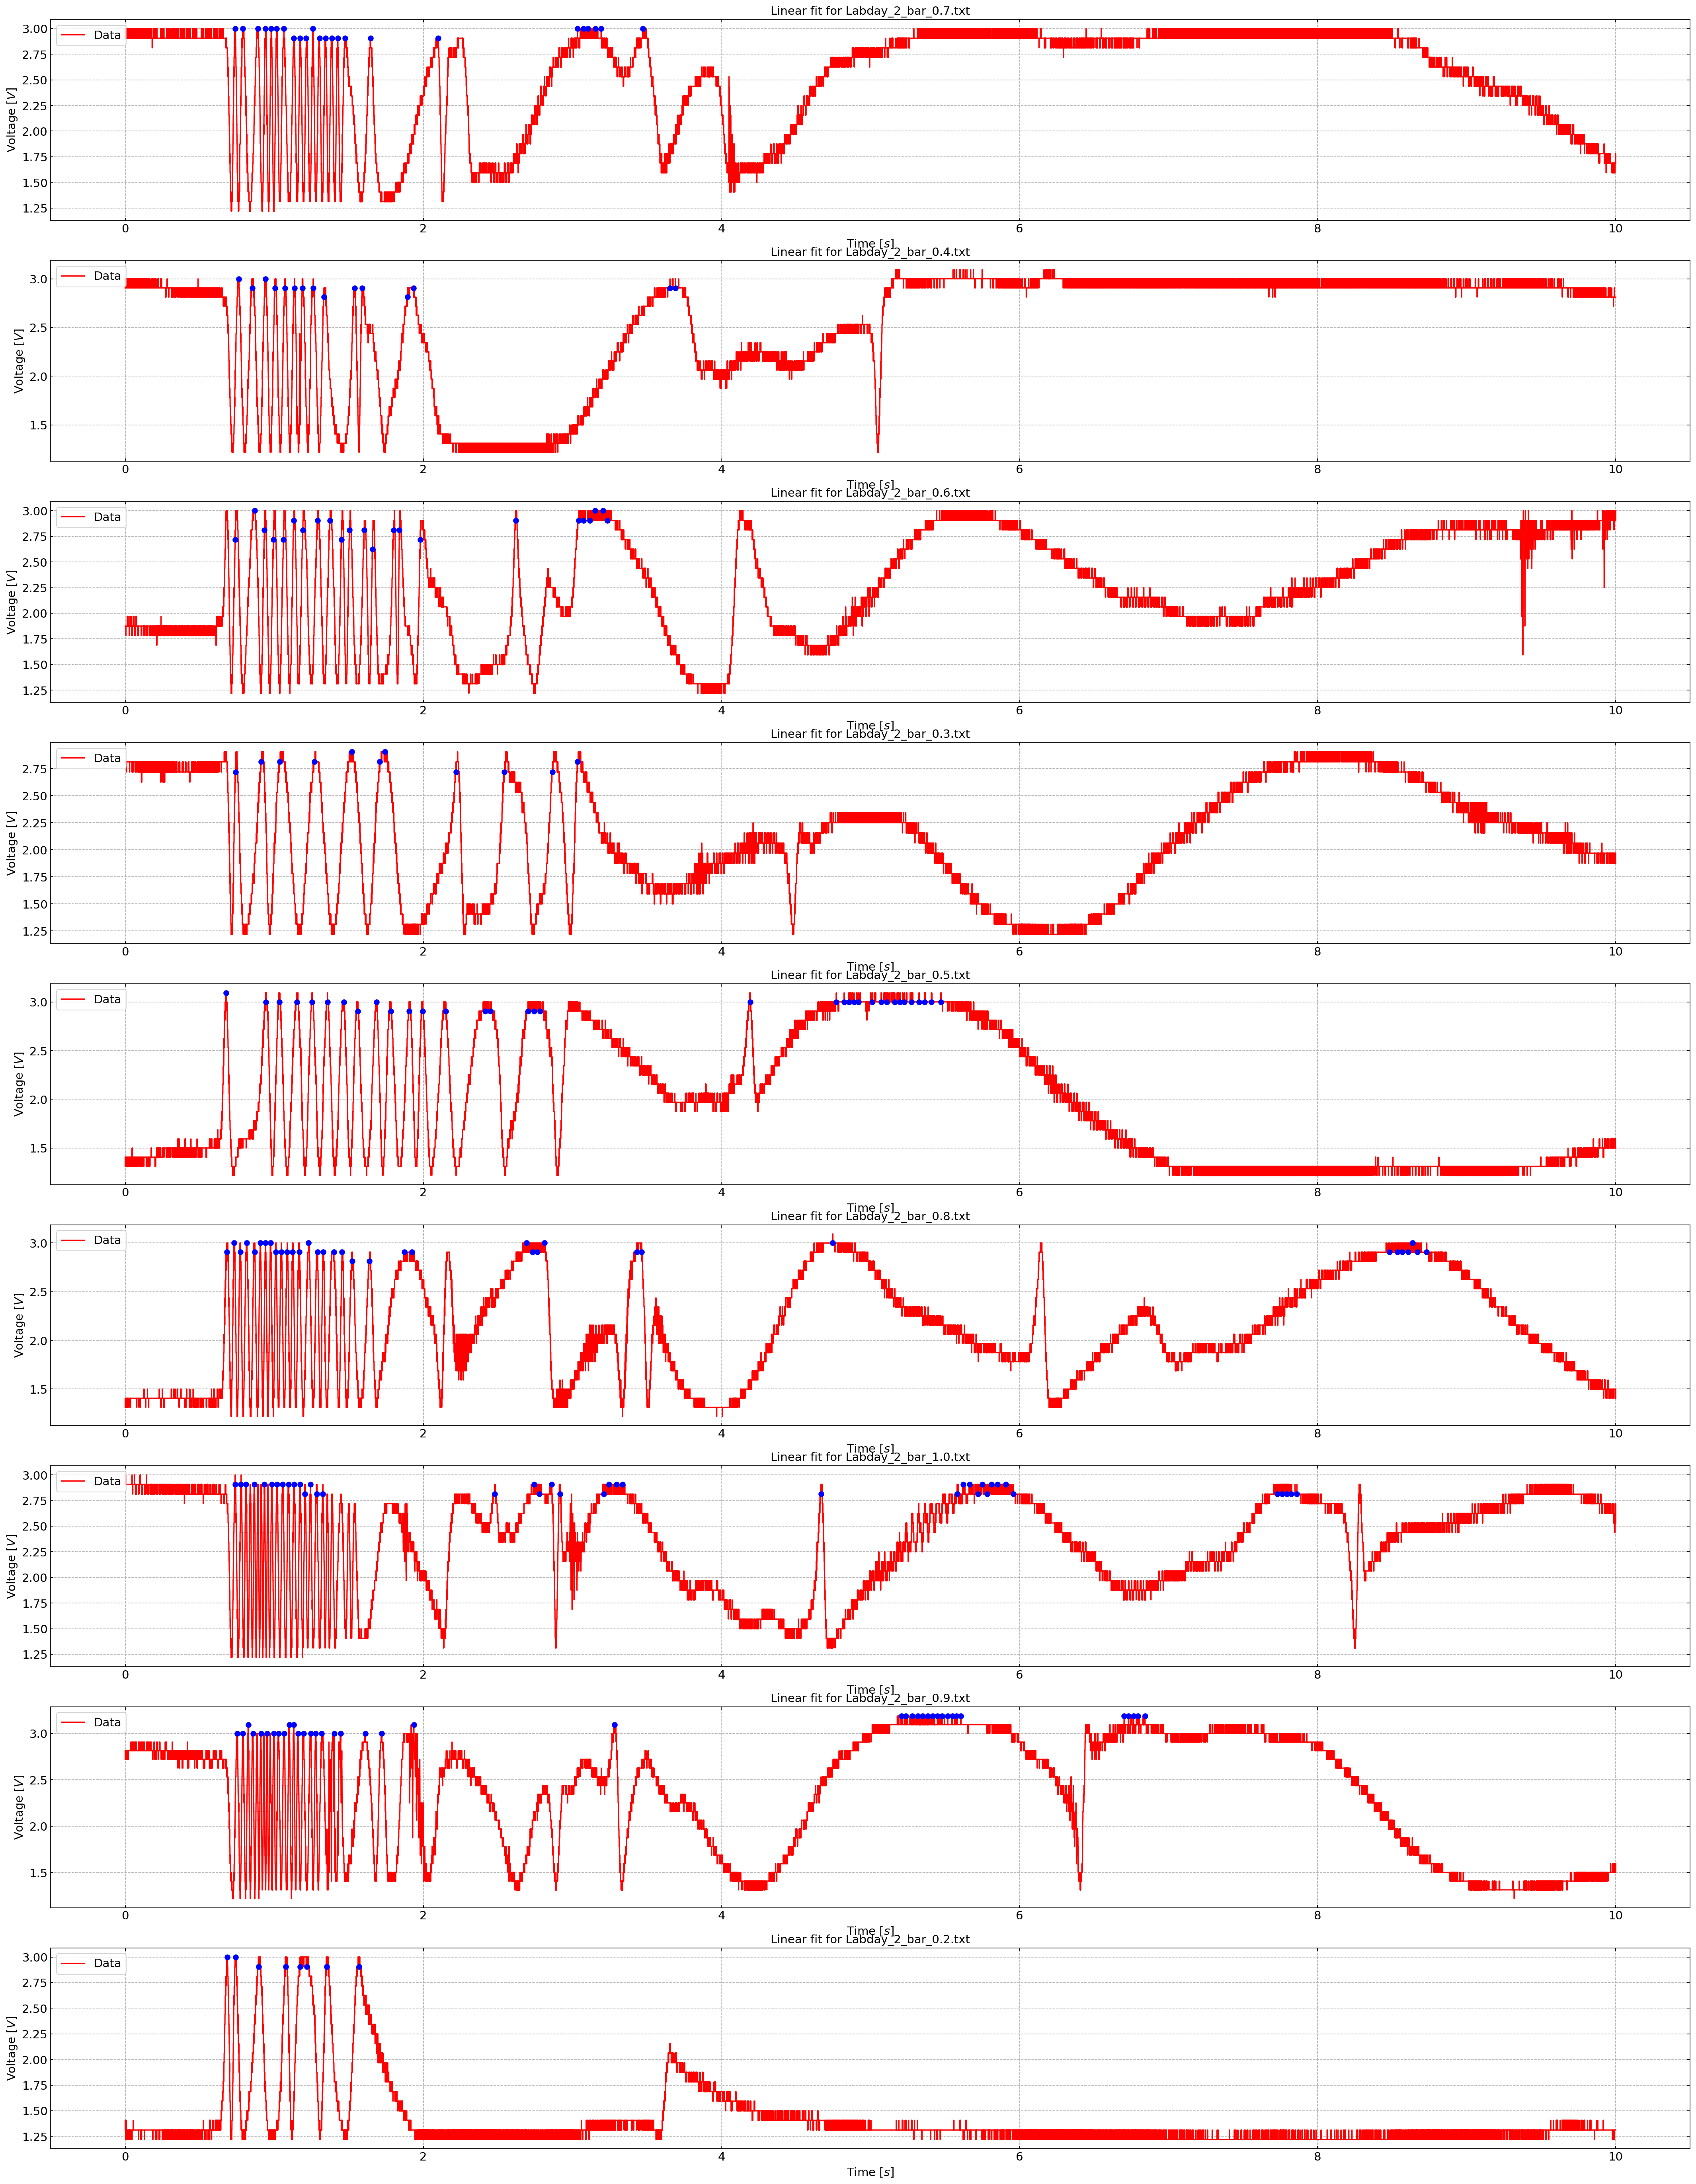

In [49]:
#Here using subplots to get 6 graphs for each iteration together.

lin_const = []
lin_sigma = []
quad_const =[]
quad_sigma =[]

# Regular expression pattern to extract the pressure value from the file name
pattern = r'\d+\.\d+'

# Lists to store pressure values and corresponding number of peaks
pressure_values = []
peaks_list = []

fig, axes = plt.subplots(9, 1, figsize=(60*cm, 80*cm)) #figure done in inches, use this to choose a good scale

# Here is my loop where I plot for curve fits with different powers.
for i, (Data_name, data) in enumerate(zip(Data_names, V1)):
    # Extract the base name of the file
    file_name = os.path.basename(Data_name)
    
    # Extract pressure value from the file name using regular expression
    pressure_match = re.search(pattern, file_name)
    if pressure_match:
        pressure = float(pressure_match.group())
    else:
        print(f"Warning: Pressure value not found in file name: {file_name}")
        continue
    
    # Find the index where voltage data starts to rise (assuming data starts from a flat line)
    start_index = np.argmax(np.diff(data) > 0)

    # Detect peaks in the dataset
    peaks, _ = find_peaks(V1[i][start_index:], prominence=1.591, distance=286.5)
    
    num_peaks = len(peaks)
    peaks_list.append(num_peaks)
    pressure_values.append(pressure)
    
    # Linear fit
    plt.sca(axes[i])  # Set current axis to the current subplot

    plt.title(f'Linear fit for {file_name}')

    plt.plot(time[i], V1[i], ls='-', label='Data', color='red')  # Plot data points
    x_peaks = [time[i][peak] for peak in peaks]
    v_peaks = [V1[i][peak] for peak in peaks]
    plt.plot(x_peaks, v_peaks, 'o', color='blue')
    plt.xlabel('Time [$s$]')
    plt.ylabel('Voltage [$V$]')
    plt.grid(ls='--')
    plt.legend()

# Show the final plot with all 9 subplots together
plt.show()


In [50]:
#Read the values found and then can adjust
peaks_list, pressure_values

([24, 15, 23, 11, 35, 36, 40, 40, 8],
 [0.7, 0.4, 0.6, 0.3, 0.5, 0.8, 1.0, 0.9, 0.2])

In [51]:
#adjust actual values
#
#peaks_list=[23, 14, 22, 12, 18, 30, 32, 29, 9]
peaks_list=[17, 10, 16, 12, 15, 22, 20, 21, 8]

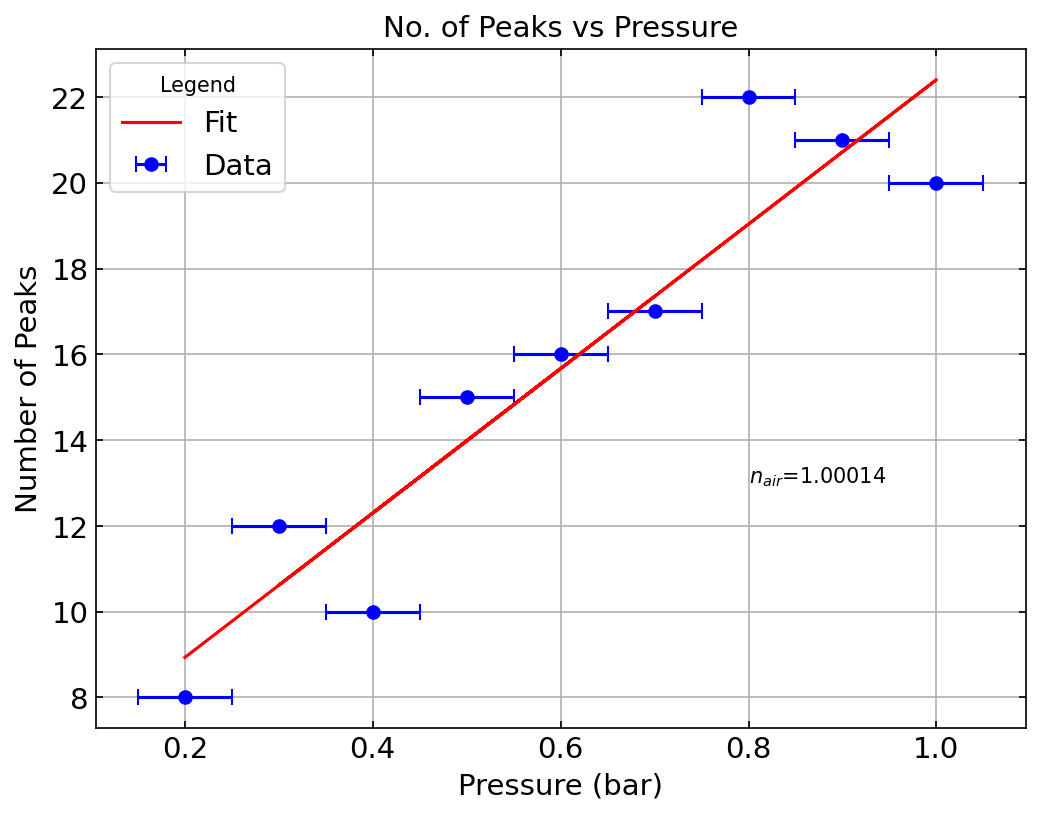

n_air = 1.0001420733339876


In [52]:
l = 633e-9 #Wavelength of light
L = 0.075 #Length of tube used in metre
p = 101325 #atmospheric pressure

# Function for linear fit
def linear(x, m, b):
    return m * np.array(x) + b

#Some guess lol
p0 = [35, 1.017] 

# Perform linear fit
popt, pcov = sp.curve_fit(linear, pressure_values, peaks_list, p0=p0)

# Extracting slope and y-intercept
slope, intercept = popt

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(pressure_values, peaks_list, xerr = 0.05, fmt = 'o', capsize = 4, color = 'blue', label = 'Data')
plt.plot(pressure_values, linear(pressure_values, *popt), color='red', label="Fit")
n_air = 1 + l/L * slope
plt.xlabel('Pressure (bar)')
plt.ylabel('Number of Peaks')
plt.title('No. of Peaks vs Pressure')
plt.legend(title = 'Legend')
plt.grid(True)
plt.text(0.8, 13, "$n_{air}$" + f'={n_air:.06g}')
plt.show()
# Print the result
print("n_air =", n_air)

In [53]:
#percentage difference:
n_actual = 1.00027717
diff =(slope-n_actual)/((slope+n_actual)/2)*100
diff

177.56422536053358

In [54]:
l = 633e-9 #Wavelength of light
L = 0.075 #Length of tube used in metre
p = 101325 #atmospheric pressure


n_air = 1 + l/L * slope
# Print the result
print("n_air =", n_air)

n_air = 1.0001420733339876


In [55]:
a_L = 0.0005

a_n = np.sqrt((-(l*slope)/L**2)**2*(a_L)**2+(l/L)**2*pcov[0,0])

print("m =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)
print("n=", n_air, "+/-", a_n)


m = 16.833333410852035 +/- 2.389626978987144
b = 5.566666616110426 +/- 1.560897820344001
n= 1.0001420733339876 +/- 2.019067972448843e-05


Idea to analyze the data:
- Measure the pressure
- Count the peaks by filtering the right places of the data out or by setting a limit of when a peak can be seen as peak
- For each measurement save the number of peaks and the number of valid peaks and fit them linearly
- Use the result as the refraction index of compressed air which can be used to find the refraction index of air, by fitting the data to a sine curve